# Fraud Detection Model

###### Modified Data orignally come from Kaggle https://www.kaggle.com/datasets/isabbaggin/transaction-fraudulent-financial-syntheticdata/data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, auc, roc_curve

import joblib

#### Read data from the Excel file

In [2]:
data_transactions = pd.read_csv('synthetic_financial_data.csv')
data_transactions.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,01/01/2023 00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,19010.56,01/01/2023 00:00,1,American Express,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,12480.86,01/01/2023 00:00,1,American Express,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,76190.05,01/01/2023 00:00,1,Discover,City-6,Gas Station,59,Purchase at Merchant-2037
4,5,1036,2083,18900.10,01/01/2023 00:00,1,American Express,City-34,Retail,36,Purchase at Merchant-2083


### Exploratory Data Analysis

In [3]:
data_transactions.shape

(10000, 11)

In [4]:
data_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [5]:
data_transactions.nunique()

transaction_id             10000
customer_id                  100
merchant_id                  100
amount                      9966
transaction_time             167
is_fraudulent                  2
card_type                      4
location                      50
purchase_category              6
customer_age                  53
transaction_description      100
dtype: int64

In [6]:
data_transactions.is_fraudulent.value_counts()
# We can see that we have a balanced dataset

1    5068
0    4932
Name: is_fraudulent, dtype: int64

In [7]:
fraud_ratio = data_transactions.is_fraudulent.value_counts()/len(data_transactions)
fraud_ratio

1    0.5068
0    0.4932
Name: is_fraudulent, dtype: float64

In [8]:
data_transactions.isnull().sum()
# No missing values 

transaction_id             0
customer_id                0
merchant_id                0
amount                     0
transaction_time           0
is_fraudulent              0
card_type                  0
location                   0
purchase_category          0
customer_age               0
transaction_description    0
dtype: int64

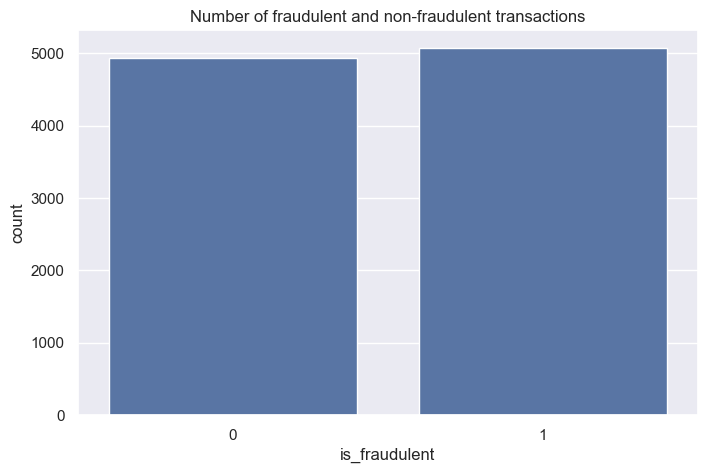

In [9]:
plt.figure(figsize= (8, 5))

sns.countplot(x = 'is_fraudulent', data = data_transactions)
plt.title('Number of fraudulent and non-fraudulent transactions')
plt.show()

<Figure size 1200x800 with 0 Axes>

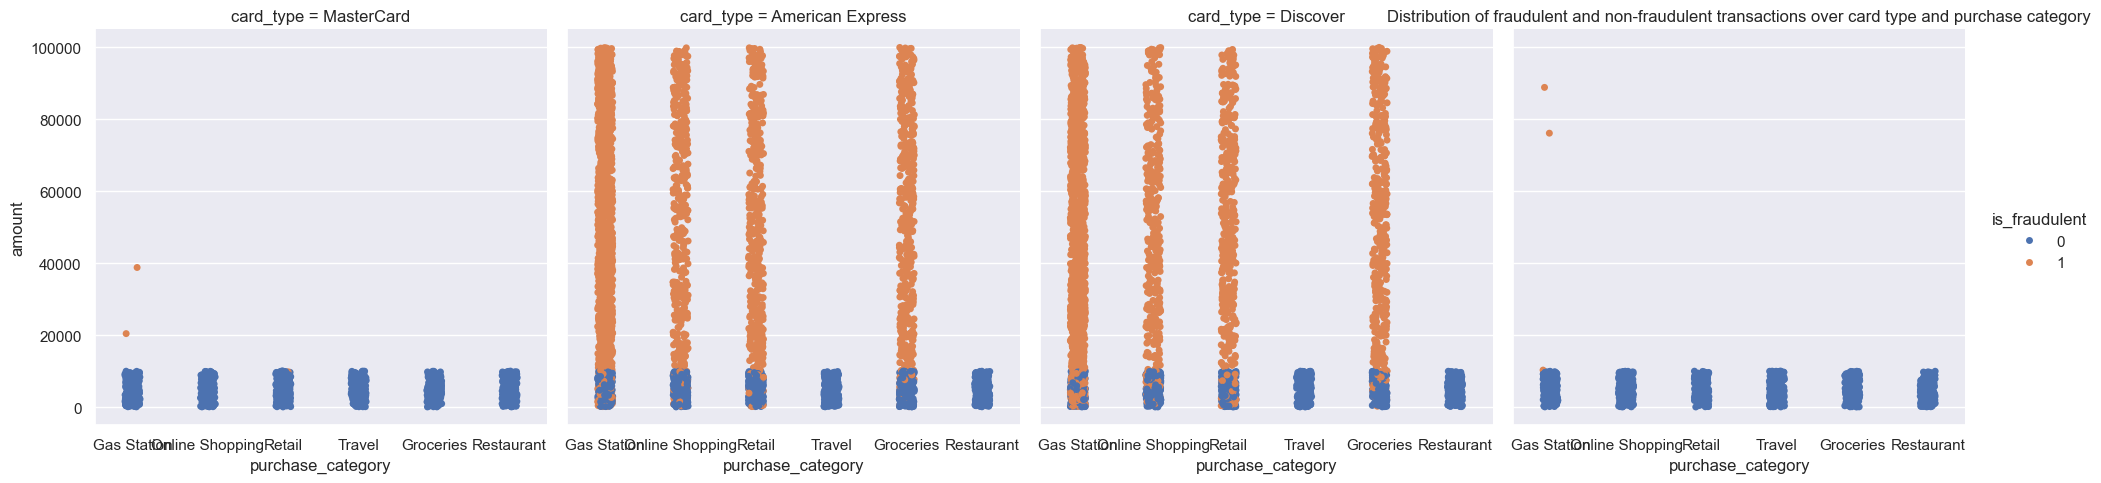

In [10]:
plt.figure(figsize = (12, 8))

sns.catplot(x = 'purchase_category', y='amount', estimator = sum, hue = 'is_fraudulent', col='card_type', data = data_transactions)
plt.title('Distribution of fraudulent and non-fraudulent transactions over card type and purchase category')
plt.show()

In [11]:
min_time = min(data_transactions['transaction_time'])
min_time

'01/01/2023 00:00'

In [12]:
max_time = max(data_transactions['transaction_time'])
max_time

'01/01/2023 02:46'

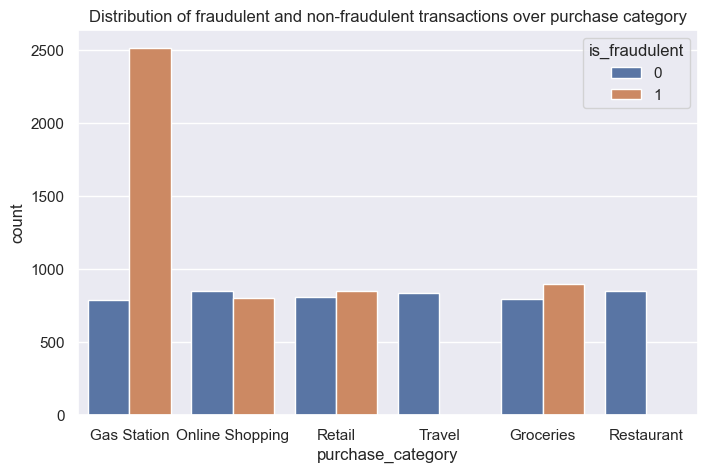

In [13]:
plt.figure(figsize = (8, 5))

sns.countplot(x = 'purchase_category', hue = 'is_fraudulent', data = data_transactions)
plt.title('Distribution of fraudulent and non-fraudulent transactions over purchase category')
plt.show()

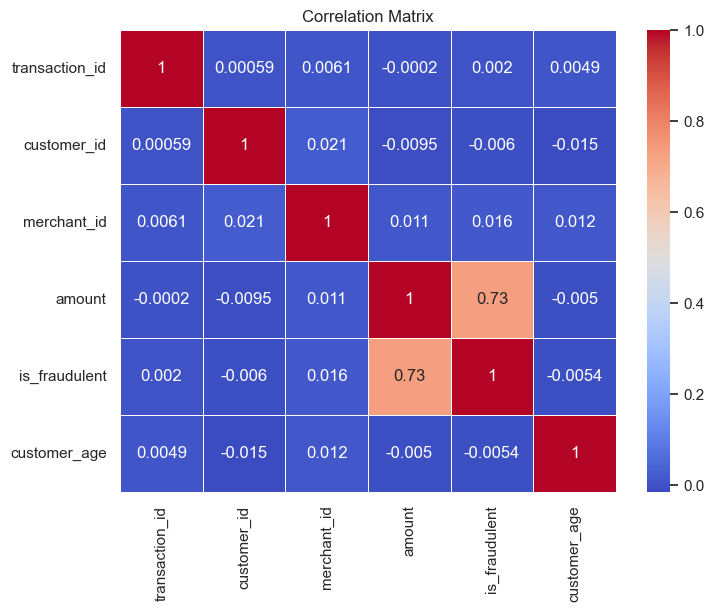

In [14]:
correlation_matrix = data_transactions.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.4)
plt.title('Correlation Matrix')
plt.show()

### Feature engineering - Feature creation, transformation, extraction, selection

In [15]:
data_transactions['customer_id'] = data_transactions['customer_id'].astype(str)
data_transactions['merchant_id'] = data_transactions['merchant_id'].astype(str)

In [16]:
# Created a new feature - company-merchant pair interaction
data_transactions['transaction_from_to_pair'] = data_transactions['customer_id'] + '_' + data_transactions['merchant_id']
data_transactions.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_from_to_pair
0,1,1082,2027,5758.59,01/01/2023 00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027,1082_2027
1,2,1015,2053,19010.56,01/01/2023 00:00,1,American Express,City-47,Online Shopping,61,Purchase at Merchant-2053,1015_2053
2,3,1004,2035,12480.86,01/01/2023 00:00,1,American Express,City-6,Gas Station,57,Purchase at Merchant-2035,1004_2035
3,4,1095,2037,76190.05,01/01/2023 00:00,1,Discover,City-6,Gas Station,59,Purchase at Merchant-2037,1095_2037
4,5,1036,2083,18900.10,01/01/2023 00:00,1,American Express,City-34,Retail,36,Purchase at Merchant-2083,1036_2083


In [17]:
# Created a new feature - track new interactions between customer-company (first time)
data_transactions['is_new_interaction'] = data_transactions.groupby('transaction_from_to_pair')['transaction_time'].transform('min') == data_transactions['transaction_time']
data_transactions['is_new_interaction'] = data_transactions['is_new_interaction'].astype(int)
data_transactions

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_from_to_pair,is_new_interaction
0,1,1082,2027,5758.59,01/01/2023 00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027,1082_2027,1
1,2,1015,2053,19010.56,01/01/2023 00:00,1,American Express,City-47,Online Shopping,61,Purchase at Merchant-2053,1015_2053,1
2,3,1004,2035,12480.86,01/01/2023 00:00,1,American Express,City-6,Gas Station,57,Purchase at Merchant-2035,1004_2035,1
3,4,1095,2037,76190.05,01/01/2023 00:00,1,Discover,City-6,Gas Station,59,Purchase at Merchant-2037,1095_2037,1
4,5,1036,2083,18900.10,01/01/2023 00:00,1,American Express,City-34,Retail,36,Purchase at Merchant-2083,1036_2083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,89350.28,01/01/2023 02:46,1,Discover,City-39,Gas Station,36,Purchase at Merchant-2023,1056_2023,1
9996,9997,1053,2026,30.15,01/01/2023 02:46,0,MasterCard,City-32,Retail,42,Purchase at Merchant-2026,1053_2026,0
9997,9998,1041,2034,6333.64,01/01/2023 02:46,0,American Express,City-1,Online Shopping,36,Purchase at Merchant-2034,1041_2034,0
9998,9999,1009,2019,28370.13,01/01/2023 02:46,1,Discover,City-11,Retail,57,Purchase at Merchant-2019,1009_2019,0


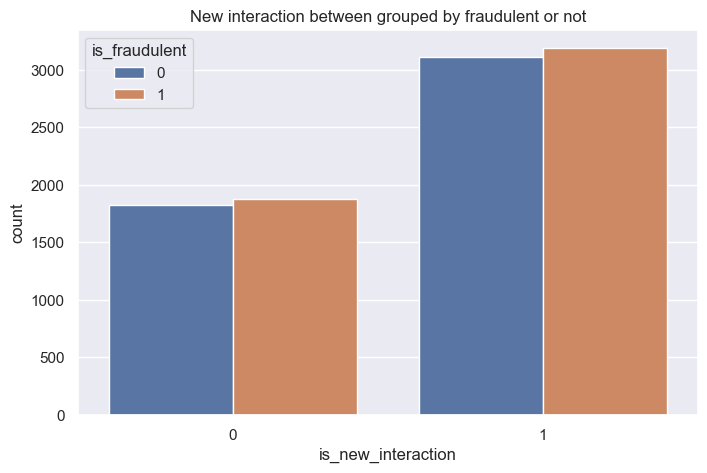

In [18]:
plt.figure(figsize = (8, 5))
sns.countplot(x = 'is_new_interaction', hue = 'is_fraudulent', data = data_transactions)
plt.title('New interaction between grouped by fraudulent or not')
plt.show()

In [19]:
# Dropped 'transaction_from_to_pair' since it's just for flagging new interactions
data_transactions = data_transactions.drop('transaction_from_to_pair', axis=1)

In [20]:
data_transactions['customer_id'] = data_transactions['customer_id'].astype(int)
data_transactions['merchant_id'] = data_transactions['merchant_id'].astype(int)

In [21]:
data_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int32  
 2   merchant_id              10000 non-null  int32  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
 11  is_new_interaction       10000 non-null  int32  
dtypes: float64(1), int32(3), int64(3), object(5)
memory usage: 820.4+ KB


In [22]:
# Created additional feature to capture whether large transactions tend to be suspicious when they happen between companies interacting for the first time
data_transactions['amount_new_interaction'] = data_transactions['amount'] * data_transactions['is_new_interaction']

In [23]:
# Created a new feature - track how often a given merchant (or customer) has appeared in past transactions. This can be an indicator of fraud if certain merchants/customers are frequently or rarely involved in transactions
data_transactions['customer_transaction_count'] = data_transactions.groupby('customer_id')['customer_id'].transform('count')
data_transactions['merchant_transaction_count'] = data_transactions.groupby('merchant_id')['merchant_id'].transform('count')

In [24]:
# Selected which attributes can be excluded from the model. Transaction id, transaction_time (as we have transactions
# from the same day and within only 3 hours), transaction_description - are not relevant
data_transactions = data_transactions.drop(['transaction_id', 'transaction_time', 'transaction_description'], axis=1)
data_transactions

,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,is_new_interaction,amount_new_interaction,customer_transaction_count,merchant_transaction_count
0,1082,2027,5758.59,0,MasterCard,City-30,Gas Station,43,1,5758.59,111,112
1,1015,2053,19010.56,1,American Express,City-47,Online Shopping,61,1,19010.56,103,95
2,1004,2035,12480.86,1,American Express,City-6,Gas Station,57,1,12480.86,87,83
3,1095,2037,76190.05,1,Discover,City-6,Gas Station,59,1,76190.05,103,97
4,1036,2083,18900.10,1,American Express,City-34,Retail,36,1,18900.10,100,105
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1056,2023,89350.28,1,Discover,City-39,Gas Station,36,1,89350.28,88,104
9996,1053,2026,30.15,0,MasterCard,City-32,Retail,42,0,0.00,101,107
9997,1041,2034,6333.64,0,American Express,City-1,Online Shopping,36,0,0.00,107,104
9998,1009,2019,28370.13,1,Discover,City-11,Retail,57,0,0.00,99,117


#### Encoding

In [25]:
# Label Encoding for Categorical Features (treating customer_id and merchant_id as categorical features that carry on meaning)
label_encoders = {}
for col in ['customer_id', 'merchant_id']:
    le = LabelEncoder()
    data_transactions[col] = le.fit_transform(data_transactions[col])
    label_encoders[col] = le

In [26]:
# Taking into consideration nature of card type, purchase category and location attributes, I conducted One-Hot Encoding
data_transactions = pd.get_dummies(data_transactions, columns=['card_type', 'purchase_category', 'location'], drop_first=True)  # drop_first=True avoids dummy variable trap

In [27]:
# Scaled numerical categories
scaler = StandardScaler()
data_transactions[['amount', 'customer_age', 'amount_new_interaction', 'customer_transaction_count', 'merchant_transaction_count']] = scaler.fit_transform(data_transactions[['amount', 'customer_age', 'amount_new_interaction', 'customer_transaction_count', 'merchant_transaction_count']])

In [28]:
data_transactions

,customer_id,merchant_id,amount,is_fraudulent,customer_age,is_new_interaction,amount_new_interaction,customer_transaction_count,merchant_transaction_count,card_type_Discover,...,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,81,26,-0.715316,0,-0.068370,1,-0.422072,1.088531,1.024140,0,...,0,0,0,0,0,0,0,0,0,0
1,14,52,-0.282093,1,1.106492,1,0.055665,0.230186,-0.582666,0,...,0,1,0,0,0,0,0,0,0,0
2,3,34,-0.495556,1,0.845411,1,-0.179732,-1.486502,-1.716882,0,...,0,0,0,0,0,0,1,0,0,0
3,94,36,1.587175,1,0.975952,1,2.117000,0.230186,-0.393630,1,...,0,0,0,0,0,0,1,0,0,0
4,35,82,-0.285704,1,-0.525261,1,0.051683,-0.091693,0.362514,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,55,22,2.017399,1,-0.525261,1,2.591430,-1.379209,0.267996,1,...,0,0,0,0,0,0,0,0,0,0
9996,52,25,-0.902585,0,-0.133641,0,-0.629670,0.015600,0.551550,0,...,0,0,0,0,0,0,0,0,0,0
9997,40,33,-0.696517,0,-0.525261,0,-0.629670,0.659358,0.267996,0,...,0,0,0,0,0,0,0,0,0,0
9998,8,18,0.023883,1,0.845411,0,-0.629670,-0.198986,1.496730,1,...,0,0,0,0,0,0,0,0,0,0


#### Assign feature weights based on the knowledge domain to adjust their influence on the model

In [29]:
# Feature Weights
feature_weights = {
    'amount': 1.5,
    'customer_age': 1.0,
    'is_new_interaction': 1.4,
    'amount_new_interaction': 1.5,
    'customer_transaction_count': 1.2,
    'merchant_transaction_count': 1.2,
    'card_type_Discover': 1.0,
    'card_type_MasterCard': 1.0,
    'card_type_Visa': 1.0,
    'purchase_category': 1.0,
    'location': 1.0
}

In [30]:
# Apply weights
for feature, weight in feature_weights.items():
    if feature in data_transactions.columns:
        data_transactions[feature] = data_transactions[feature] * weight

#### Building the model

In [31]:
X = data_transactions.drop('is_fraudulent', axis=1)
y = data_transactions['is_fraudulent']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Logistic Regression

In [33]:
logistic_clf = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
logistic_clf.fit(X_train, y_train)
y_pred_logistic = logistic_clf.predict(X_test)

# Model evaluation
print('Logistic Regression\n')
print('Accuracy:', accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_logistic)}')

# AUC for logistic regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic)
AUC_logistic = auc(fpr_logistic, tpr_logistic)
print('\n AUC for Logistic Regression:', AUC_logistic)

Logistic Regression

Accuracy: 0.938
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       966
           1       0.97      0.91      0.94      1034

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion Matrix:
 [[933  33]
 [ 91 943]]

 AUC for Logistic Regression: 0.9389153861864314


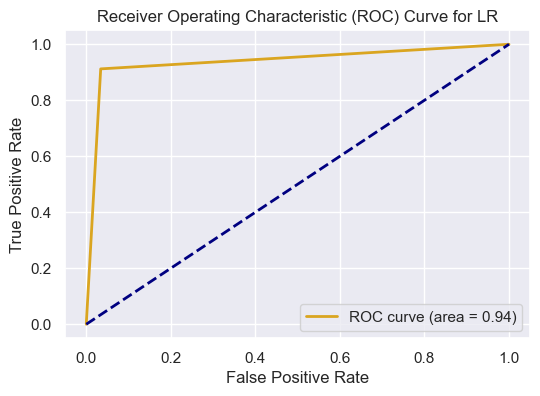

In [34]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_logistic, tpr_logistic, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LR')
plt.legend(loc='lower right')
plt.show()

#### Random Forest

In [35]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Model Evaluation
print('Random Forest\n')
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_rf)}')

# AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
AUC_rf = auc(fpr_rf, tpr_rf)
print('\n AUC for Logistic Regression:', AUC_rf)

Random Forest

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.90      0.95      1034

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Confusion Matrix:
 [[966   0]
 [100 934]]

 AUC for Logistic Regression: 0.9516441005802707


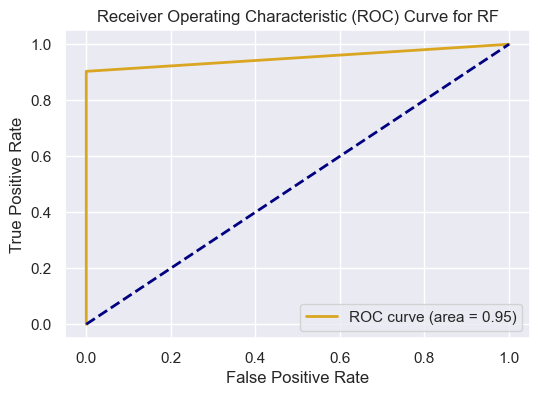

In [36]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RF')
plt.legend(loc='lower right')
plt.show()

#### Support Vector Machine

In [37]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)

# Model Evaluation
print('SVC\n')
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(classification_report(y_test, y_pred_svc))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_svc)}')

# AUC for SVC
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_svc)
AUC_svc = auc(fpr_svc, tpr_svc)
print('\n AUC for SVC:', AUC_svc)

SVC

Accuracy: 0.8285
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       966
           1       1.00      0.67      0.80      1034

    accuracy                           0.83      2000
   macro avg       0.87      0.83      0.83      2000
weighted avg       0.87      0.83      0.82      2000

Confusion Matrix:
 [[966   0]
 [343 691]]

 AUC for SVC: 0.8341392649903288


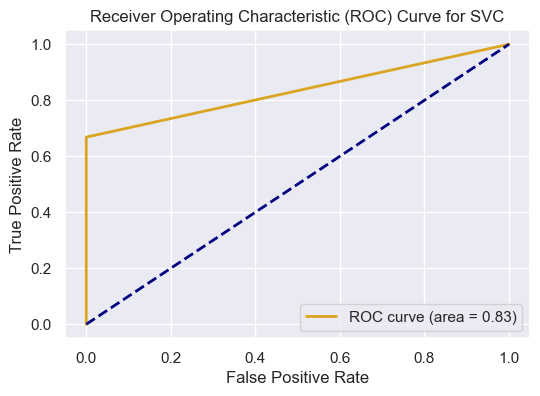

In [38]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_svc, tpr_svc, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC')
plt.legend(loc='lower right')
plt.show()

#### XGBoost 

In [39]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

# Model Evaluation
print('XGBoost\n')
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb)}')

# AUC for SVC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
AUC_xgb = auc(fpr_xgb, tpr_xgb)
print('\n AUC for XGBoost:', AUC_xgb)

XGBoost

Accuracy: 0.945
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       966
           1       0.97      0.92      0.95      1034

    accuracy                           0.94      2000
   macro avg       0.95      0.95      0.94      2000
weighted avg       0.95      0.94      0.95      2000

Confusion Matrix:
 [[940  26]
 [ 84 950]]

 AUC for XGBoost: 0.9459234875516097


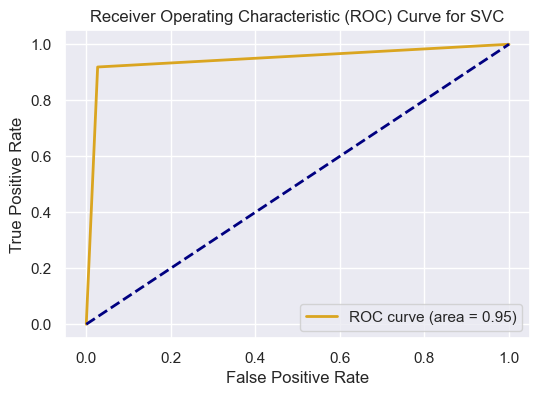

In [40]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_xgb, tpr_xgb, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC')
plt.legend(loc='lower right')
plt.show()

#### Naive Bayes

In [41]:
gaussianNB_classifier = GaussianNB()
gaussianNB_classifier.fit(X_train,y_train)
y_pred_gaussianNB = gaussianNB_classifier.predict(X_test)

# Model Evaluation
print('Naive Bays\n')
print(f"Accuracy: {accuracy_score(y_test, y_pred_gaussianNB)}")
print(classification_report(y_test, y_pred_gaussianNB))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_gaussianNB)}')

# AUC for SVC
fpr_gaussianNB, tpr_gaussianNB, _ = roc_curve(y_test, y_pred_gaussianNB)
AUC_gaussianNB = auc(fpr_gaussianNB, tpr_gaussianNB)
print('\n AUC for Naive Bays:', AUC_gaussianNB)

Naive Bays

Accuracy: 0.827
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       966
           1       0.75      1.00      0.86      1034

    accuracy                           0.83      2000
   macro avg       0.87      0.82      0.82      2000
weighted avg       0.87      0.83      0.82      2000

Confusion Matrix:
 [[ 620  346]
 [   0 1034]]

 AUC for Naive Bays: 0.8209109730848861


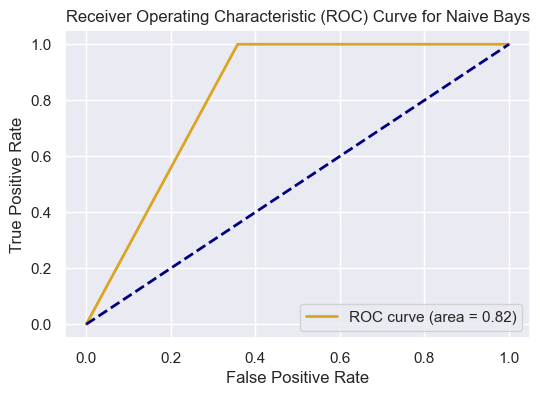

In [42]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_gaussianNB, tpr_gaussianNB, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_gaussianNB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bays')
plt.legend(loc='lower right')
plt.show()

#### Decision Tree

In [43]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train,y_train)
y_pred_decision_tree = decision_tree_classifier.predict(X_test)

# Model Evaluation
print('Decision Tree\n')
print(f"Accuracy: {accuracy_score(y_test, y_pred_decision_tree)}")
print(classification_report(y_test, y_pred_decision_tree))
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_decision_tree)}')

# AUC for SVC
fpr_decision_tree, tpr_decision_tree, _ = roc_curve(y_test, y_pred_decision_tree)
AUC_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)
print('\n AUC for Decision Tree:', AUC_decision_tree)

Decision Tree

Accuracy: 0.9225
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       966
           1       0.92      0.93      0.93      1034

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Confusion Matrix:
 [[883  83]
 [ 72 962]]

 AUC for Decision Tree: 0.922223089891915


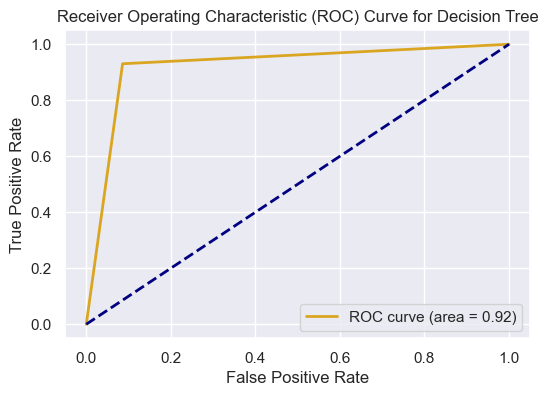

In [44]:
# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr_decision_tree, tpr_decision_tree, color='goldenrod', lw=2, label=f'ROC curve (area = {AUC_decision_tree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

### Print and compare accuracy for all models

Accuracy for Logistic Regression: 0.938
Accuracy for Gaussian Naive Bayes: 0.827
Accuracy for Decision Tree: 0.925
Accuracy for Random Forest: 0.950
Accuracy for Support Vector Machine: 0.829
Accuracy for XGBoost: 0.945

Best performing model: Random Forest with accuracy 0.950


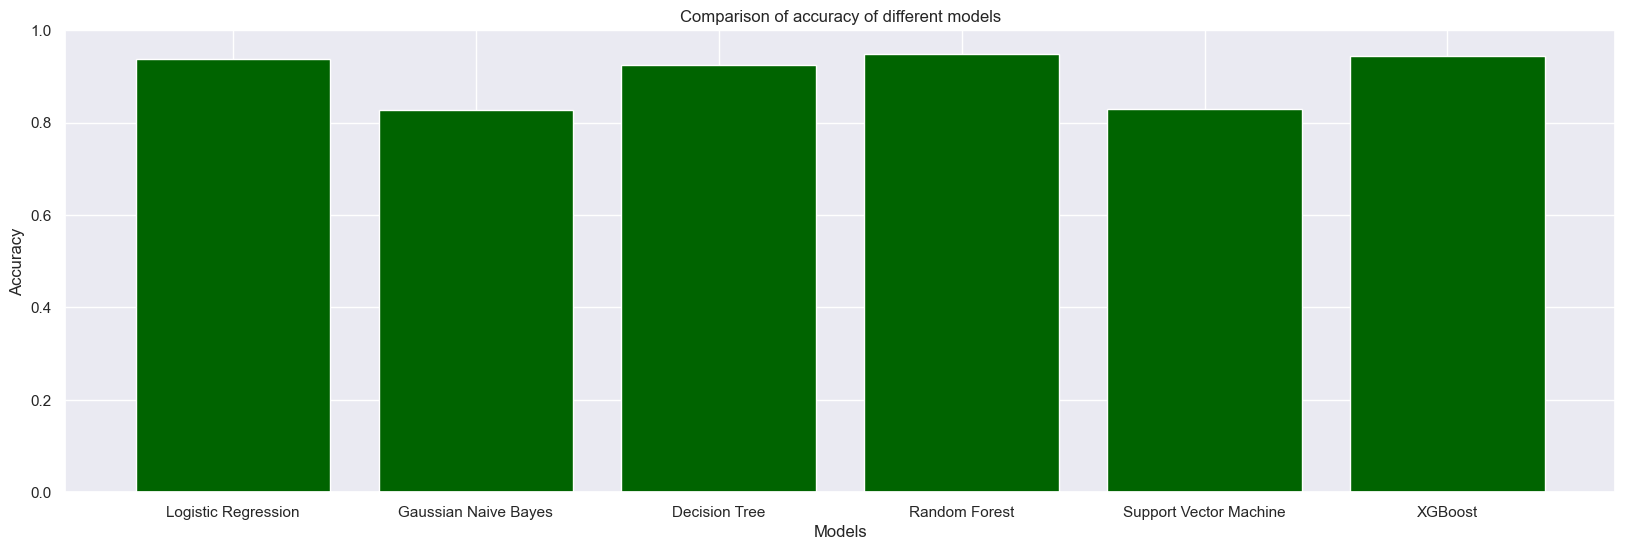

In [45]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' :  RandomForestClassifier(),
    'Support Vector Machine' : SVC(),
    'XGBoost' : xgb.XGBClassifier()
}

accuracies = []
best_accuracy = 0
best_model = None
best_model_name = ''

for model_name, model in models.items():
    # Train model on scaled data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy for {model_name}: {accuracy:.3f}')
    
    # Keep track of the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name

# Print the best performing model
print(f"\nBest performing model: {best_model_name} with accuracy {best_accuracy:.3f}")

# Create a bar plot for the accuracies
plt.figure(figsize=(20, 6))
plt.bar(models.keys(), accuracies, color='darkgreen')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of accuracy of different models')
plt.ylim([0, 1])
plt.show()

In [46]:
# Save the best model and preprocessing objects
joblib.dump(best_model, 'best_model.pkl')         
joblib.dump(scaler, 'scaler.pkl')                 
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']